# **Fox Vs Dog**


In [49]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [50]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of fox and dogs

In [51]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a fox photo and a dog photo
and seeing what kind of result we get. We'll start by getting URLs from a search:

In [52]:
urls = search_images('fox photos', max_images=1)
urls[0]

Searching for 'fox photos'


'https://i.pinimg.com/originals/67/f9/2e/67f92e258297942f00aab9f31706e353.jpg'

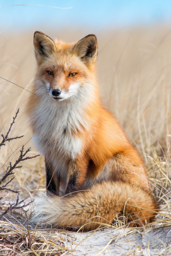

In [53]:
from fastdownload import download_url
dest = 'fox.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "dog photos":

Searching for 'dog photos'


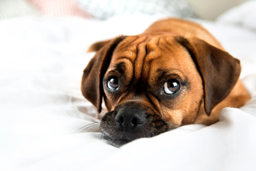

In [54]:
download_url(search_images('dog photos', max_images=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

In [55]:
searches = 'dog','fox'
path = Path('fox_or_dog')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} hunt photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} run photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} eating photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'dog hunt photo'
Searching for 'dog run photo'
Searching for 'dog eating photo'
Searching for 'fox photo'
Searching for 'fox hunt photo'
Searching for 'fox run photo'
Searching for 'fox eating photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [56]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

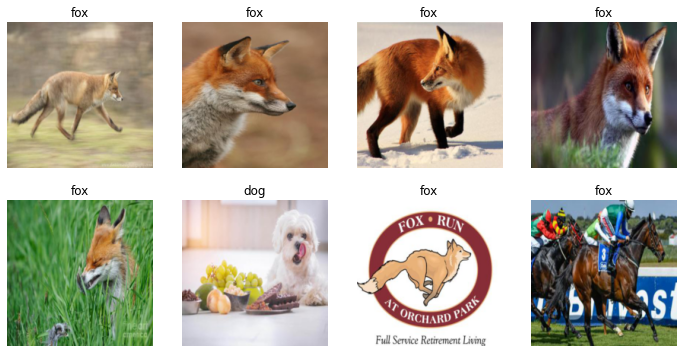

In [57]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

In [58]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.512396,0.087679,0.018657,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.102347,0.032936,0.014925,00:04
1,0.060939,0.001848,0.000000,00:05
2,0.036818,0.009060,0.011194,00:05


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [59]:
is_fox,_,probs = learn.predict(('dog.jpg'))
print(f"Probability it's a dog and not fox: {probs[0]:.4f}")

Probability it's a dog and not fox: 1.0000
